<a href="https://colab.research.google.com/github/SeraphDev6/Pnuemonia_Image_Classification/blob/main/Pneumonia_X_Ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Classification by Wesley Giles

## Data Citation
Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## Load data and necessary modules

In [1]:
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# ! unzip chest-xray-pneumonia.zip
# ! pip install imagehash

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage import io
import seaborn as sns
from PIL import Image
from imagehash import average_hash
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

## Let's start with checking for duplicate images
### Code refactored from example by [Somil Shah](https://medium.com/@somilshah112/how-to-find-duplicate-or-similar-images-quickly-with-python-2d636af9452f)

In [3]:
def find_duplicates(root):
  known_hashes = {}
  duplicates = []
  for cls in ["NORMAL","PNEUMONIA"]:
    for path in [os.path.join(root,cls,d) for d in os.listdir(os.path.join(root, cls))]:
      with Image.open(path) as img:
        hash = average_hash(img)
        if hash in known_hashes:
          duplicates.append(path)
        else:
          known_hashes[hash] = path
  return duplicates

dupes = find_duplicates("/content/chest_xray/train/")
len(dupes)

0

## Wow 254 duplicates. Let's drop these and check the other directories for duplicates

In [4]:
def drop_files(paths):
  for path in paths:
    os.remove(path)
drop_files(dupes)
print(f"Training duplicates: {len(find_duplicates('/content/chest_xray/train/'))}")
print(f"Testing duplicates: {len(find_duplicates('/content/chest_xray/test/'))}")
print(f"Validation duplicates: {len(find_duplicates('/content/chest_xray/val/'))}")

Training duplicates: 0
Testing duplicates: 0
Validation duplicates: 0


## Now that we know the drop files works, lets drop the duplicated testing images

In [5]:
drop_files(find_duplicates('/content/chest_xray/test/'))

## Lets take a look at the balance of the train data

In [6]:
def get_file_counts(root):
  di = {}
  for dir in [d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]:
    di[dir] = len([f for f in os.listdir(os.path.join(root,dir)) if os.path.isfile(os.path.join(root,dir,f))])
  return di
get_file_counts("/content/chest_xray/train/")

{'NORMAL': 1260, 'PNEUMONIA': 3702}

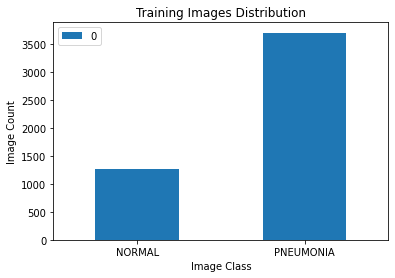

In [7]:
def get_bal_chart(root,title = None):
  bal = pd.DataFrame.from_dict(get_file_counts(root), orient = "index")
  bal.plot.bar()
  plt.gca().set_xlabel("Image Class")
  plt.gca().set_ylabel("Image Count")
  plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation = 0)
  if title:
    plt.gca().set_title(title)
  plt.show()
get_bal_chart("/content/chest_xray/train/","Training Images Distribution")

## Seems we have significantly more Pnuemonia images than normal in this dataset, lets check test and val to ensure the same balance is in those sets

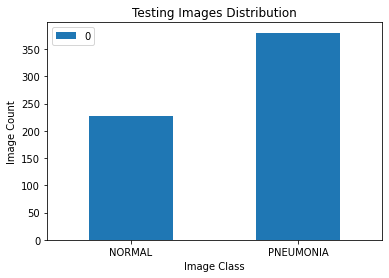

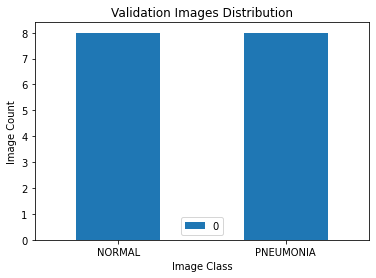

In [8]:
get_bal_chart("/content/chest_xray/test/", "Testing Images Distribution")
get_bal_chart("/content/chest_xray/val/", "Validation Images Distribution")

## While not perfectly balanced, both the train and test are skewed towards the positive indicator, which will allow us to more accurately predict Pnuemonia.

## Let's try to get some data on the attributes of the images

In [9]:
def average_brightness(path):
  return io.imread(path).mean(axis=0).mean(axis=0).mean()

In [10]:
def get_average_brightness_df(root):
  data = []
  for dir in ["NORMAL","PNEUMONIA"]:
    data += [(average_brightness(os.path.join(root,dir,im)), dir, os.path.join(root,dir,im)) for im in os.listdir(os.path.join(root,dir))]
  return pd.DataFrame(data, columns = ["Average Brightness","Classification","Path"]) 
df = get_average_brightness_df("/content/chest_xray/train/")

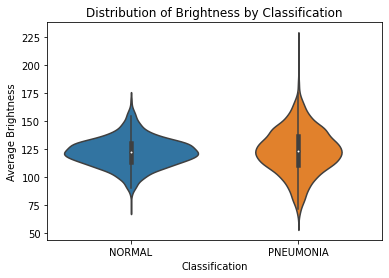

In [11]:
sns.violinplot(data = df, 
              x = "Classification",
              y = "Average Brightness")
plt.gca().set_title("Distribution of Brightness by Classification")
plt.show()

## It looks like there are several images with a very high brightness. Let's take a look at those

In [12]:
high_sat = df[df['Average Brightness']>190]
high_sat

,Average Brightness,Classification,Path
2059,201.838906,PNEUMONIA,/content/chest_xray/train/PNEUMONIA\person1405...
2090,221.536623,PNEUMONIA,/content/chest_xray/train/PNEUMONIA\person1413...
2330,193.691671,PNEUMONIA,/content/chest_xray/train/PNEUMONIA\person1510...


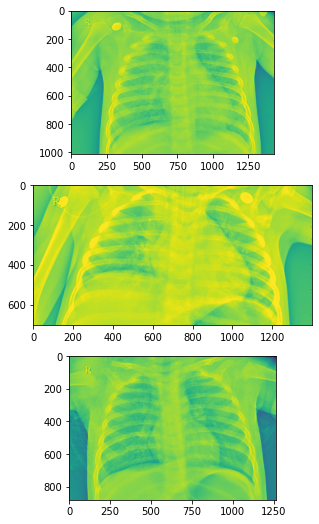

In [13]:
fig, axes = plt.subplots(len(high_sat),figsize = (5,9))
for idx, image in enumerate(high_sat["Path"]):
  axes[idx].imshow(Image.open(image))

## These images are still likely to work with the dataset. We just have to ensure the images are normalized in our model

## Now let's go ahead and set up the streams to get the images from the directories

In [32]:
IMG_HEIGHT, IMG_WIDTH = 256,256
image_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255)

train_gen = image_gen.flow_from_directory("/content/chest_xray/train/",
                                          target_size=(IMG_HEIGHT,IMG_WIDTH),
                                          class_mode = "binary",
                                          classes=["NORMAL","PNEUMONIA"])
test_gen = image_gen.flow_from_directory("/content/chest_xray/test/",
                                          target_size=(IMG_HEIGHT,IMG_WIDTH),
                                          class_mode = "binary",
                                          classes=["NORMAL","PNEUMONIA"])
val_gen = image_gen.flow_from_directory("/content/chest_xray/val/",
                                          target_size=(IMG_HEIGHT,IMG_WIDTH),
                                          class_mode = "binary",
                                          classes=["NORMAL","PNEUMONIA"])

Found 4962 images belonging to 2 classes.
Found 608 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## It seems like the Pneumonia data set has a wider range of Average Brightness than the normal, likely due to the larger data set. Let's visualize some of the images

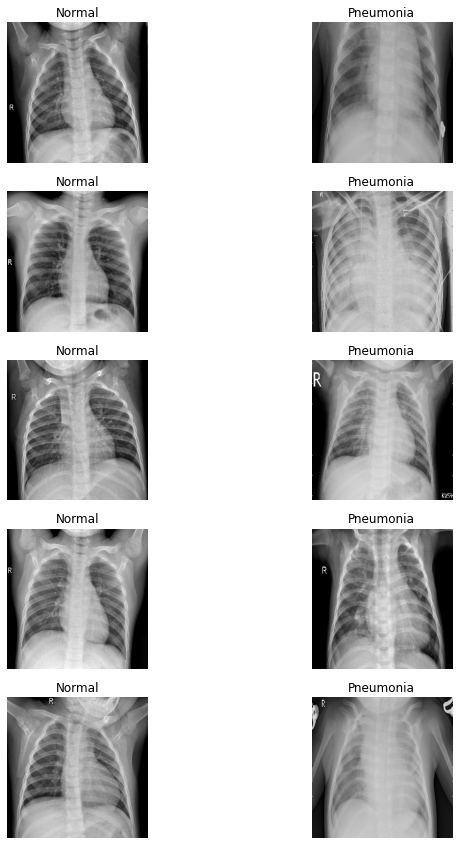

In [34]:
def show_image_samples(image_list, class_list):
  fig, axes = plt.subplots(5,2, figsize= (10,15))
  num_normal, num_pneumonia = 0, 0
  for idx, image in enumerate(image_list):
    if class_list[idx] == 0 and num_normal < 5:
      ax = axes[num_normal,0]
      ax.imshow(image)
      ax.axis("off")
      ax.set_title("Normal")
      num_normal += 1 
    elif class_list[idx] == 1 and num_pneumonia < 5 :
      ax = axes[num_pneumonia,1]
      ax.imshow(image)
      ax.axis("off")
      ax.set_title("Pneumonia")
      num_pneumonia += 1
  plt.show()

show_image_samples(*next(train_gen))

## Now let's design the model using keras

In [39]:
def get_model(num_layers = 1):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(16, 3, activation = "relu", input_shape = (IMG_HEIGHT,IMG_WIDTH, 3)))
    model.add(keras.layers.MaxPooling2D())
    for i in range(1,num_layers):
        model.add(keras.layers.Conv2D(32, 3, activation = "relu"))
        model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation="relu"))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(1, activation = "sigmoid"))

    model.compile(
        optimizer = "adam",
        loss = "bce",
        metrics = ["accuracy"]
    )

    return model

model = get_model(2)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 123008)            0         
                                                                 
 dense_17 (Dense)            (None, 32)               

## Now let's fit the model with an early stopping callback to prevent overfitting

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta = 0.0001, patience = 5, restore_best_weights=True)

history = model.fit(x = train_gen,
                    epochs = 100,
                    validation_data = test_gen,
                    callbacks = [early_stopping]
                    )

Epoch 1/100
156/156 [==============================] - 63s 399ms/step - loss: 0.4189 - accuracy: 0.8400 - val_loss: 0.6389 - val_accuracy: 0.7829
Epoch 2/100
156/156 [==============================] - 61s 390ms/step - loss: 0.1178 - accuracy: 0.9412 - val_loss: 0.6542 - val_accuracy: 0.7911
Epoch 3/100
156/156 [==============================] - 62s 396ms/step - loss: 0.0942 - accuracy: 0.9526 - val_loss: 1.4740 - val_accuracy: 0.6859
Epoch 4/100
156/156 [==============================] - 61s 389ms/step - loss: 0.0729 - accuracy: 0.9734 - val_loss: 1.5725 - val_accuracy: 0.6941
Epoch 5/100
156/156 [==============================] - 62s 398ms/step - loss: 0.0654 - accuracy: 0.9764 - val_loss: 0.9671 - val_accuracy: 0.7599
Epoch 6/100
156/156 [==============================] - 64s 408ms/step - loss: 0.0557 - accuracy: 0.9778 - val_loss: 1.0632 - val_accuracy: 0.7878


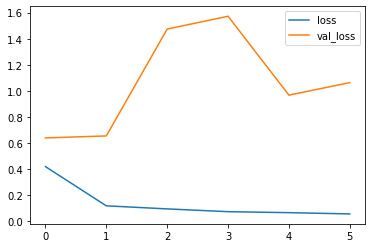

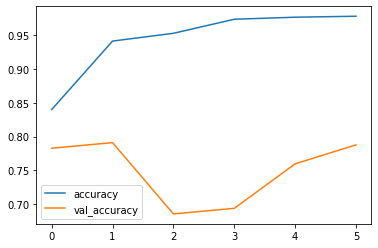

In [49]:
def plot_hist(hist):
  for metric in hist.history:
    if metric[:3] != "val":
      plt.plot(hist.history[metric], label = metric)
      if f"val_{metric}" in hist.history:
        plt.plot(hist.history[f"val_{metric}"], label = f"val_{metric}")
      plt.legend()
      plt.show()
plot_hist(history)

## Seeing these fit results it seems clear that the model is overfitted. The probelm is we don't have enough training images to effectively provide new input. Lets modify our `train_gen` to apply some small deformations to the train images, effectively giving us additional data

In [42]:
train_data_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255,
                                                              horizontal_flip = True,
                                                              vertical_flip = True,
                                                              rotation_range = 360.0,
                                                              height_shift_range = 0.2,
                                                              width_shift_range = 0.2,
                                                              zoom_range = 0.2)

mod_train_gen = train_data_gen.flow_from_directory("/content/chest_xray/train/",
                                          target_size=(IMG_HEIGHT,IMG_WIDTH),
                                          class_mode = "binary",
                                          classes=["NORMAL","PNEUMONIA"])


Found 4962 images belonging to 2 classes.


## Let's go ahead and try fitting a new model with the updated image gen

In [43]:
new_model =  get_model(3)

new_hist = new_model.fit(x = mod_train_gen,
              epochs = 100,
              validation_data = test_gen,
              callbacks = [early_stopping]
              )

Epoch 1/100
156/156 [==============================] - 104s 663ms/step - loss: 0.4277 - accuracy: 0.7888 - val_loss: 0.4970 - val_accuracy: 0.6809
Epoch 2/100
156/156 [==============================] - 103s 661ms/step - loss: 0.3848 - accuracy: 0.8170 - val_loss: 0.5637 - val_accuracy: 0.6645
Epoch 3/100
156/156 [==============================] - 103s 660ms/step - loss: 0.3599 - accuracy: 0.8388 - val_loss: 0.5470 - val_accuracy: 0.7401
Epoch 4/100
156/156 [==============================] - 101s 648ms/step - loss: 0.4340 - accuracy: 0.7793 - val_loss: 0.9119 - val_accuracy: 0.6365
Epoch 5/100
156/156 [==============================] - 102s 650ms/step - loss: 0.3581 - accuracy: 0.8436 - val_loss: 0.4320 - val_accuracy: 0.7878
Epoch 6/100
156/156 [==============================] - 101s 650ms/step - loss: 0.3463 - accuracy: 0.8523 - val_loss: 0.5589 - val_accuracy: 0.7401
Epoch 7/100
156/156 [==============================] - 101s 648ms/step - loss: 0.3385 - accuracy: 0.8470 - val_loss: 0

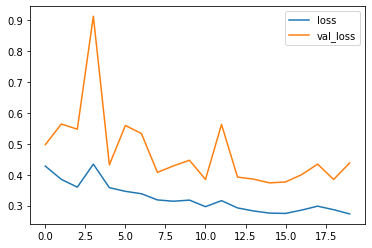

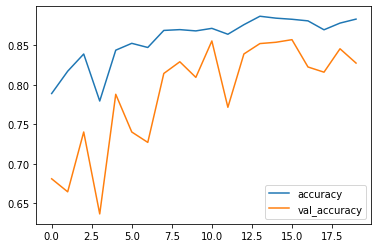

In [44]:
plot_hist(new_hist)

## Definitley a better result this time. Lets see if we can get some insight into the model using Lime

In [45]:
! pip install lime

from lime import lime_image
from skimage.segmentation import mark_boundaries

c:\Users\wesle\anaconda3\envs\ml_standard\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
images, classifications = test_gen.next()
explainer = lime_image.LimeImageExplainer()

100%|██████████| 1000/1000 [00:08<00:00, 113.78it/s]
C:\Users\wesle\AppData\Local\Temp\ipykernel_27996\1417804067.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


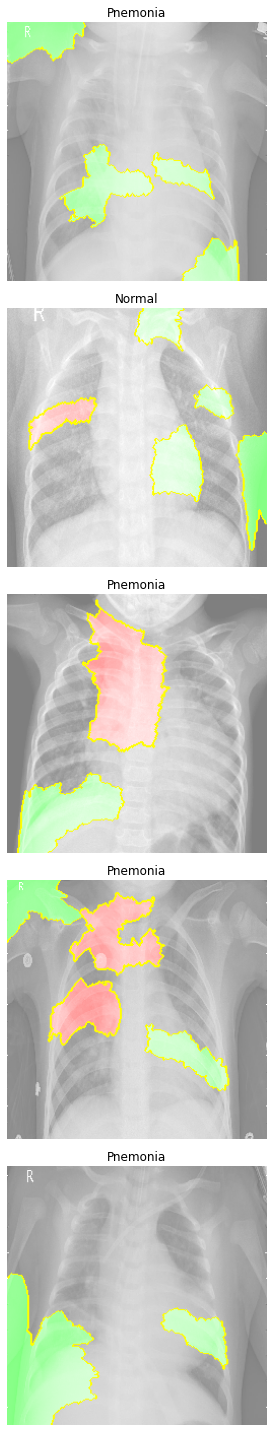

In [68]:
# Big thanks to James M. Irving, Ph.D. for help with getting Lime to function correctly
def get_lime_explainations(model):
  fig, axes = plt.subplots(5, figsize = (10,20))
  for i in range(5):
    explanation = explainer.explain_instance(images[i], new_model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=5)
    axes[i].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    axes[i].axis("off")
    axes[i].set_title("Pnemonia" if classifications[i] else "Normal")
  fig.tight_layout()
  fig.show()
get_lime_explainations(model)

100%|██████████| 1000/1000 [00:08<00:00, 121.99it/s]
C:\Users\wesle\AppData\Local\Temp\ipykernel_27996\1417804067.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


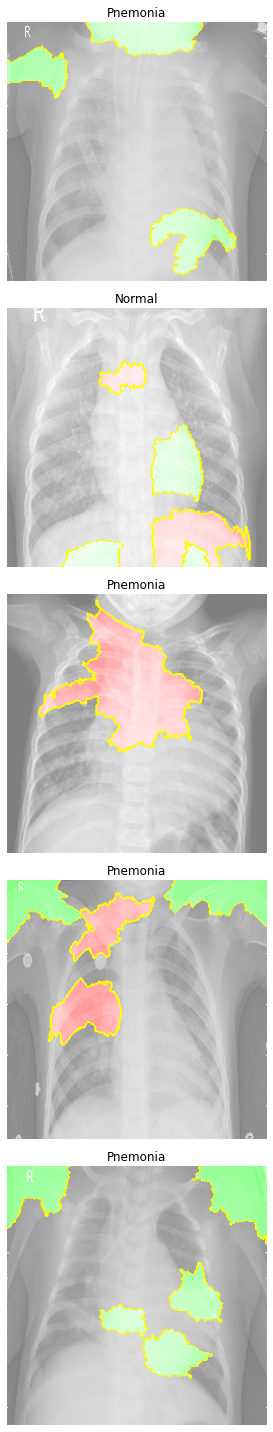

In [69]:
get_lime_explainations(new_model)

## The figure above shows the postive and negative (indicated by green and red respectively) correlations of classifications. The odd thing about these results is that the features the model is looking at seems to be primarily outside of the lungs, rather than inside. This indicates a significant amount of bias based on the positioning of the subject, and leads me to believe that this model will work well for this dataset but may be entirely ineffective for other hospitals, or patients who are seen by other X-ray technicians.

## Just to confirm this let's test both of the models on the Validation data set

              precision    recall  f1-score   support

         0.0       1.00      0.62      0.77         8
         1.0       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



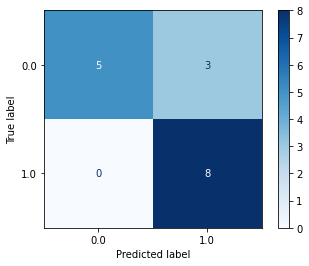

In [54]:
def display_results(model):
  val_img, classes =  val_gen.next()
  preds = np.rint(model.predict(val_img)).flatten()
  print(classification_report(classes,preds))
  ConfusionMatrixDisplay.from_predictions(classes,preds, cmap="Blues")
display_results(model)

              precision    recall  f1-score   support

         0.0       1.00      0.38      0.55         8
         1.0       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16



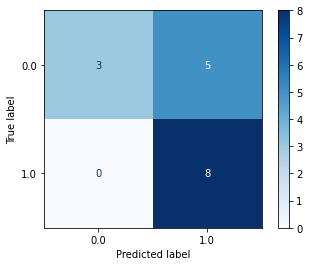

In [55]:
display_results(new_model)

## As could be predicted with the balance of our test data the model was very good at picking up Pneumonia cases but not as proficient at picking out normal lungs. This combined with the abnormal areas of interest tells us we need a much wider data sample in order to train this model effecitvely. While this may not be a working model for the current problem, it proves the potential of a model which can determine illness from X-ray images.